In [17]:
import sys
import os
import cdsapi
import cfgrib
import xarray as xr

from time import sleep

In [22]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import utils.multicrop_dataset as multicrop_dataset
import utils.architecture as architecture

tf.random.set_seed(0)
np.random.seed(0)

options = tf.data.Options()
options.experimental_optimization.noop_elimination = True             # eliminate no-op transformations
tf.compat.v1.data.experimental.OptimizationOptions.map_vectorization = True    # vectorize map transformations
options.experimental_optimization.apply_default_optimizations = True  # apply default graph optimizations
options.experimental_deterministic = True                            # False disable deterministic order
options.threading.max_intra_op_parallelism = 1           # overrides the maximum degree of intra-op parallelism 

In [23]:
BS = 16 
SIZE_CROPS = [50, 32]  
NUM_CROPS= [2,3]

#SCALE FOR CROPPING
MIN_SCALE = [0.7, 0.5]
MAX_SCALE = [1., 0.7]

PROTOTYPES = 15
PROPORTIONS = [] #to not use proportions declare it as empty list

#check
if len(PROPORTIONS):
    PROTOTYPES = len(PROPORTIONS)

MODEL_TAG  = ''

In [25]:
data = np.load('data/test_data.npy')
data = tf.data.Dataset.from_tensor_slices(data) 

# Get multiple data loaders
trainloaders = multicrop_dataset.get_multires_dataset(data,
    size_crops=SIZE_CROPS,
    num_crops=NUM_CROPS,
    min_scale=MIN_SCALE,
    max_scale=MAX_SCALE,
    options=options)

trainloaders_zipped = tf.data.Dataset.zip(trainloaders)

trainloaders_zipped = (
        trainloaders_zipped
        .batch(BS)
        .prefetch( tf.data.experimental.AUTOTUNE)
    )

2024-06-04 14:11:06.431324: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-04 14:11:06.918119: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-04 14:11:06.918219: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-04 14:11:06.935931: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-04 14:11:06.936061: I tensorflow/compile

2024-06-04 14:11:10.988066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_30' with dtype float and shape [3701,50,67,3]
	 [[{{node Placeholder/_30}}]]
2024-06-04 14:11:10.988704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype float and shape [3701,50,67,3]
	 [[{{node Placeholder/_20}}]]


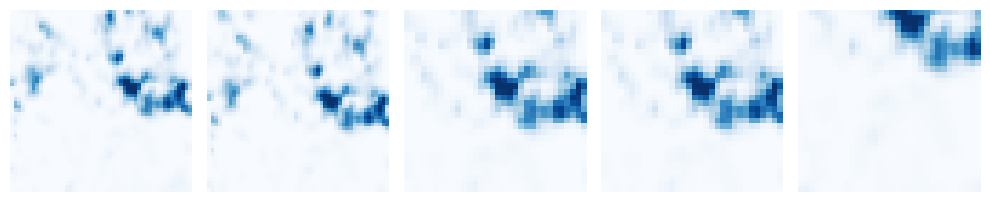

In [26]:
images = [i[3] for i in next(iter(trainloaders_zipped))]

fig, axes = plt.subplots(1, 5, figsize=(10, 7))

for ax, img in zip(axes.ravel(), images):
    ax.imshow(img,cmap='Blues')
    ax.axis('off')

# If there are more axes than images, turn off the remaining axes
for ax in axes.ravel()[len(images):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [27]:
feature_backbone = architecture.get_resnet_backbone()
projection_prototype = architecture.get_projection_prototype(prototype_dimension = PROTOTYPES)

In [28]:
feature_backbone.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 encoder (Functional)        (None, None, None, 512)   11182080  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
Total params: 11,182,080
Trainable params: 11,172,480
Non-trainable params: 9,600
_________________________________________________________________


In [29]:
projection_prototype.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 512)]             0         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 96)                98400     
                                                                 
 tf.math.l2_normalize (TFOpL  (None, 96)               0         
 ambda)                                                    

In [30]:
decay_steps = 1000

lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.1, decay_steps=decay_steps)

opt = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn)

In [31]:
epoch_wise_loss, models_tr = architecture.train_swav(feature_backbone,projection_prototype,
                                        trainloaders_zipped,opt,
                                        crops_for_assign=[0, 1],temperature=0.1,epochs=1,
                                        n_crops = NUM_CROPS, proto_proportions = PROPORTIONS)

feature_backbone_weights = feature_backbone.get_weights()

  0%|          | 0/232 [00:00<?, ?it/s]2024-06-04 14:11:13.831853: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-06-04 14:11:20.070618: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-06-04 14:11:21.941954: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-04 14:11:23.864070: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.20GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-04 14:11:23.865945: W tensorflow/tsl/framework

100%|█████████▉| 231/232 [11:17<00:01,  1.42s/it, loss=2.188] 2024-06-04 14:22:34.651273: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-04 14:22:35.538423: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-04 14:22:35.539242: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-04 14:22:36.116495: W

epoch: 1 loss: 2.294
Saving weights


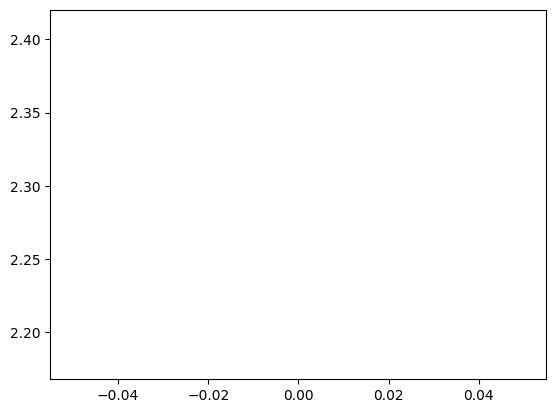

In [35]:
plt.plot(epoch_wise_loss, label='Epoch-wise Loss')
plt.axhline(y=np.log(PROTOTYPES), color='r', linestyle='--', label='ln(#prototypes)')

plt.show()